In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Performance over time

In [3]:
from src.utils.general import get_db_conn, get_boto3_session, load_model_s3, load_matrix_s3
from src.utils import project_constants as constants

In [4]:
cred_file = '../conf/local/credentials.yaml'
db_conn=get_db_conn(cred_file)
s3_session = get_boto3_session(cred_file)

In [5]:
# experiment_hash = 'b46a01d51e0c4b511e4a1aacd182a811'
# project_folder='s3://aclu-leg-tracker/experiment_data/bill_passage/triage/national_long_term_maste375r'

# experiment_hash = '102f4996db3d114aa68dda958d1446cc'
# project_folder='s3://aclu-leg-tracker/experiment_data/bill_passage/triage/national_long_term_master_new2'

experiment_hash = 'c11db389a7490536504225c05359a149'
project_folder='s3://aclu-leg-tracker/experiment_data/bill_passage/triage/national_long_term_master_final'

#### Model group evaluations

In [9]:
metric='precision@'
parameters=['10_pct', ' ']
# parameters = [' ','20_pct']

eval_q = """
    select 
        model_id,
        model_group_id,
        model_type,
        metric,
        parameter,
        stochastic_value as metric_value,
        train_end_time
    from triage_metadata.experiment_models join triage_metadata.models using(model_hash) join test_results.evaluations using(model_id)
    where experiment_hash='{exp_hash}'
    and metric='{metric}' and "parameter" in {param}
    --and model_type not like '%dummy%'
"""

precision = pd.read_sql(
    eval_q.format(
        exp_hash=experiment_hash,
        metric=metric,
        param=tuple(parameters)
    ), 
    db_conn
)

#### Precision at k_pct for the model groups

Text(0.5, 1.0, 'precision@10_pct over time for the model groups tested')

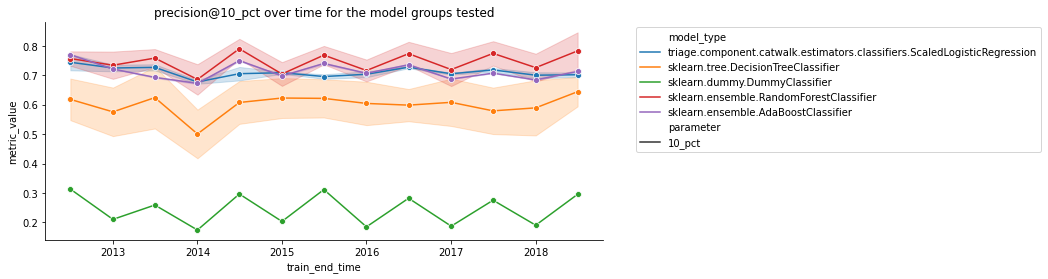

In [10]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
sns.lineplot(data=precision, x='train_end_time', y='metric_value', hue='model_type', marker='o', style='parameter', estimator='mean', ci='sd')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.set_title('{}10_pct over time for the model groups tested'.format(metric))

#### Random Forests

In [13]:
q = """
    select model_id, hyperparameters, model_type, train_end_time, model_hash, model_group_id 
    from triage_metadata.experiment_models join triage_metadata.models using(model_hash)
    where experiment_hash='{exp_hash}' 
    and model_type like '%Random%'
    order by train_end_time
""".format(
    exp_hash=experiment_hash
)

models_of_type = pd.read_sql(q, db_conn)
model_ids_rf = models_of_type['model_id'].tolist()

In [14]:
q = """
    select model_id, hyperparameters, model_type, train_end_time, model_hash, model_group_id from triage_metadata.models
    where built_by_experiment='{exp_hash}' 
    and model_type like '%Logistic%'
    order by train_end_time
""".format(
    exp_hash=experiment_hash
)
models_of_type = pd.read_sql(q, db_conn)
model_ids_lr = models_of_type['model_id'].tolist()

#### PR curve for a model

In [15]:
# msk = precision['model_group'] > 0.72
# precision.groupby('model_group_id').mean().sort_values('metric_value', ascending=False)

In [16]:
mod_group = 375
msk = precision['model_group_id'] == mod_group
# precision[msk]

In [17]:
model_ids = precision[msk]['model_id'].tolist()
q = """
    select
            model_id,
            metric,
            model_type,
            parameter,
            num_labeled_examples,
            num_labeled_above_threshold,
            num_positive_labels,
            matrix_uuid,
            best_value,
            worst_value,
            stochastic_value
        from test_results.evaluations join triage_metadata.models using(model_id)
        where model_id in {} and metric in ('recall@', 'precision@') and parameter like '%_pct' order by "parameter";
""".format(tuple(model_ids_lr))

model_evaluations = pd.read_sql(q, db_conn)

DatabaseError: Execution failed on sql '
    select
            model_id,
            metric,
            model_type,
            parameter,
            num_labeled_examples,
            num_labeled_above_threshold,
            num_positive_labels,
            matrix_uuid,
            best_value,
            worst_value,
            stochastic_value
        from test_results.evaluations join triage_metadata.models using(model_id)
        where model_id in () and metric in ('recall@', 'precision@') and parameter like '%_pct' order by "parameter";
': syntax error at or near ")"
LINE 15:         where model_id in () and metric in ('recall@', 'prec...
                                    ^


In [12]:
# q = """
#     select
#             model_id,
#             metric,
#             parameter,
#             num_labeled_examples,
#             num_labeled_above_threshold,
#             num_positive_labels,
#             matrix_uuid,
#             best_value,
#             worst_value,
#             stochastic_value
#         from test_results.evaluations where model_id in {} and metric in ('recall@', 'precision@') and parameter like '%_pct' order by "parameter";
# """.format(tuple(model_ids_lr))

# model_evaluations_lr = pd.read_sql(q, db_conn)

In [11]:
model_evaluations['perc_points'] = [int(x.split('_')[0]) for x in model_evaluations['parameter'].tolist()]
# model_evaluations_lr['perc_points'] = [int(x.split('_')[0]) for x in model_evaluations_lr['parameter'].tolist()]

NameError: name 'model_evaluations' is not defined

In [12]:
msk_prec = model_evaluations['metric']=='precision@'
fig, ax = plt.subplots(figsize=(8,5))
sns.lineplot(x='perc_points', y='stochastic_value', data=model_evaluations[msk_prec], label='precision@k', ax=ax, estimator='mean', ci='sd')
sns.lineplot(x='perc_points', y='stochastic_value', data=model_evaluations[~msk_prec], label='recall@k', ax=ax, estimator='mean', ci='sd')
ax.set_xlabel('List size percentage (k%)')
ax.set_ylabel('Metric Value')
ax.set_title('Precision and Recall over time at Different Thresholds for All Logistic Regression Models'.format(mod_group))
sns.despine()

NameError: name 'model_evaluations' is not defined

#### Recall at k_pct for the model groups

In [15]:
metric='recall@'
# parameters=['1_pct', '10_pct', '40_pct']

parameters=[' ', '10_pct']

recall = pd.read_sql(
    eval_q.format(
        exp_hash=experiment_hash,
        metric=metric,
        param=tuple(parameters)
    ), 
    db_conn
)

Text(0.5, 1.0, 'recall@k_pct over time for the model groups tested')

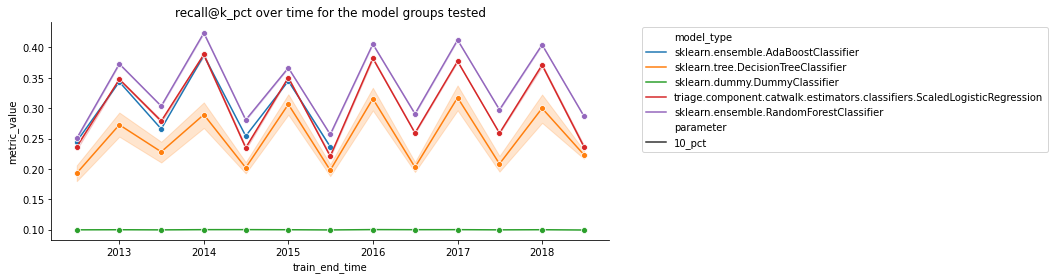

In [16]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
sns.lineplot(data=recall, x='train_end_time', y='metric_value', hue='model_type', marker='o', style='parameter')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.set_title('{}k_pct over time for the model groups tested'.format(metric))

#### Scaled Logistic Regression

In [126]:
q = """
    select model_id, model_type, train_end_time, model_hash, model_group_id from triage_metadata.models
    where built_by_experiment='{exp_hash}' 
    and model_type like '%Logistic%'
    order by train_end_time
""".format(
    exp_hash=experiment_hash
)

models_of_type = pd.read_sql(q, db_conn)

In [127]:
models_of_type

,model_id,model_type,train_end_time,model_hash,model_group_id
0,7387,triage.component.catwalk.estimators.classifier...,2012-07-01,d74a0bfe8dd32547b9dcce042e4c24ca,361
1,7388,triage.component.catwalk.estimators.classifier...,2012-07-01,c9db45a3dc56942b16fb4e6ec961a838,362
2,7381,triage.component.catwalk.estimators.classifier...,2012-07-01,9c8f3104795380be7acb0b6136bd837f,355
3,7390,triage.component.catwalk.estimators.classifier...,2012-07-01,eaf804df28c75bb89ee53775d735ecc2,363
4,7391,triage.component.catwalk.estimators.classifier...,2012-07-01,413f195c50e962a55be13db578d6276f,364
...,...,...,...,...,...
60,7698,triage.component.catwalk.estimators.classifier...,2018-07-01,6c58e266488be84538c2f87e7caad889,355
61,7699,triage.component.catwalk.estimators.classifier...,2018-07-01,b55c85fd776cad81231b5d0a5d8cf163,361
62,7700,triage.component.catwalk.estimators.classifier...,2018-07-01,b773b6bdf5a7df34b5154db802ace311,362
63,7701,triage.component.catwalk.estimators.classifier...,2018-07-01,97d9c8e175649f95bcffd7be7238bbee,363


In [128]:
msk = models_of_type['model_group_id']==361
models = models_of_type[msk]

model_ids = models['model_id'].tolist()

In [129]:
model_ids

[7387, 7413, 7439, 7461, 7508, 7517, 7543, 7569, 7595, 7620, 7647, 7671, 7699]

#### Random Forests

In [17]:
q = """
    select model_id, hyperparameters, model_type, train_end_time, model_hash, model_group_id from triage_metadata.models
    where built_by_experiment='{exp_hash}' 
    and model_type like '%Random%'
    order by train_end_time
""".format(
    exp_hash=experiment_hash
)

models_of_type = pd.read_sql(q, db_conn)

In [18]:
models_of_type

,model_id,hyperparameters,model_type,train_end_time,model_hash,model_group_id
0,7703,"{'criterion': 'gini', 'max_depth': 25, 'class_...",sklearn.ensemble.RandomForestClassifier,2012-07-01,282bdd1dbed4d0885621b176f23f67d4,365
1,7704,"{'criterion': 'gini', 'max_depth': 25, 'class_...",sklearn.ensemble.RandomForestClassifier,2012-07-01,4357ccd9461232632372df8753343491,366
2,7705,"{'criterion': 'gini', 'max_depth': 25, 'class_...",sklearn.ensemble.RandomForestClassifier,2012-07-01,3f53775807a2e4c23dd9cab15e6e24d1,367
3,7706,"{'criterion': 'gini', 'max_depth': 25, 'class_...",sklearn.ensemble.RandomForestClassifier,2012-07-01,77203a1755e65d26eb305641fae31d3b,368
4,7707,"{'criterion': 'gini', 'max_depth': 25, 'class_...",sklearn.ensemble.RandomForestClassifier,2012-07-01,af8fbed8c680c505a3b338f498e9e11e,369
...,...,...,...,...,...,...
346,8049,"{'criterion': 'gini', 'max_depth': 100, 'class...",sklearn.ensemble.RandomForestClassifier,2018-07-01,f03af9d7caaa29ade6b3de8b37184b77,387
347,8050,"{'criterion': 'gini', 'max_depth': 100, 'class...",sklearn.ensemble.RandomForestClassifier,2018-07-01,fe3dc5bc65174caa43d926064bb9a70f,388
348,8051,"{'criterion': 'gini', 'max_depth': 100, 'class...",sklearn.ensemble.RandomForestClassifier,2018-07-01,a5454183006ca52408d7f0fe5ad331e0,389
349,8052,"{'criterion': 'gini', 'max_depth': 100, 'class...",sklearn.ensemble.RandomForestClassifier,2018-07-01,15fd79aedab4e130372eff24fb7bc917,390


In [21]:
msk = models_of_type['model_group_id']==375
models = models_of_type[msk]

model_ids = models['model_id'].tolist()

In [22]:
model_ids

[7713, 7740, 7767, 7794, 7821, 7848, 7875, 7902, 7929, 7956, 7983, 8010, 8037]

#### Score buckets


In [20]:
passage_prog_in_score_buckets = pd.DataFrame()
for model in model_ids:
    q = """
        select * from test_results.predictions where model_id={model_id}
    """.format(model_id=model)
    
    predictions = pd.read_sql(q, db_conn)
    
    for i in np.arange(0.9, 0, -0.05):
        d = dict()
        d['model_id'] = model
        d['score_threshold'] = round(i, 2)
        msk = (predictions['score'] >= i) 
        d['num_records'] = predictions[msk].shape[0]
        if predictions[msk].shape[0] >0:
            d['passage_prob'] = predictions[msk]['label_value'].sum()/predictions[msk].shape[0]
        else:
            d['passage_prob']=0

        passage_prog_in_score_buckets = passage_prog_in_score_buckets.append(d, ignore_index=True)


In [35]:
df = passage_prog_in_score_buckets.merge(models, on='model_id')

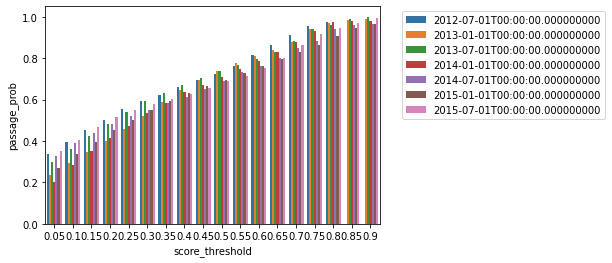

In [36]:
sns.barplot(data=df, x='score_threshold', y='passage_prob', hue='train_end_time')
plt.legend(bbox_to_anchor=(1.05, 1))

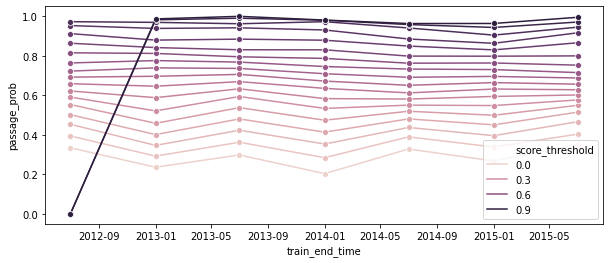

In [37]:
fig, ax = plt.subplots(figsize=(10, 4))
msk = df['score_threshold'] == 0.8
sns.lineplot(data=df, x='train_end_time', y='passage_prob', hue='score_threshold', marker='o')

#### Feature importance

In [25]:
model_hash = models.iloc[0]['model_hash']
model_id = models.iloc[0]['model_id']

q = "select matrix_uuid from test_results.prediction_metadata where model_id={}".format(model_id)
mat_uuid = pd.read_sql(q, db_conn).at[0,'matrix_uuid']
mat_uuid

'c25037808b39c40c9b87375aff26bb3b'

In [24]:
model_path='{}/trained_models/{}'.format(project_folder, model_hash)
mod = load_model_s3(s3_session, model_path)

In [26]:
mat_path = '{}/matrices/{}.csv.gz'.format(project_folder, mat_uuid)
# mat_path = 's3://aclu-leg-tracker/experiment_data/bill_passage/triage/national_long_term_master/matrices/37454418cbb077415703d117fce09614.csv.gz'
mat = load_matrix_s3(s3_session, mat_path, compression='gzip')

In [27]:
outcome_column='lt_passed'
feature_names = [x for x in mat.columns if x!=outcome_column]

In [28]:
len(feature_names)

160

In [30]:
# feat_coeff = pd.Series(mod.coef_[0], index=feature_names)

feat_coeff = pd.Series(mod.feature_importances_, index=feature_names)
feat_coeff.sort_values(ascending=False, inplace=True)

#### RF

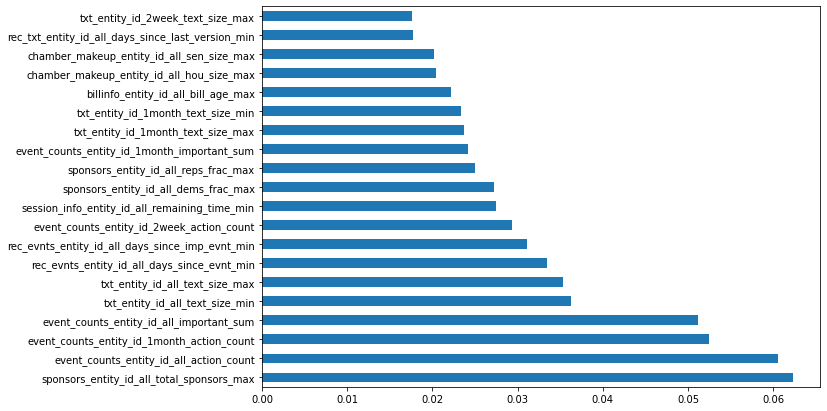

In [31]:
msk = feat_coeff > 0 
fig, ax = plt.subplots(figsize=(10, 7))
feat_coeff[msk][:20].plot(kind='barh', ax=ax)

#### DT

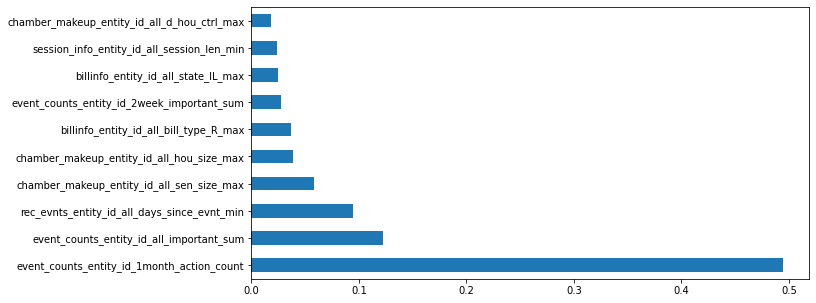

In [43]:
msk = feat_coeff > 0 
fig, ax = plt.subplots(figsize=(10, 5))
feat_coeff[msk][:10].plot(kind='barh', ax=ax)

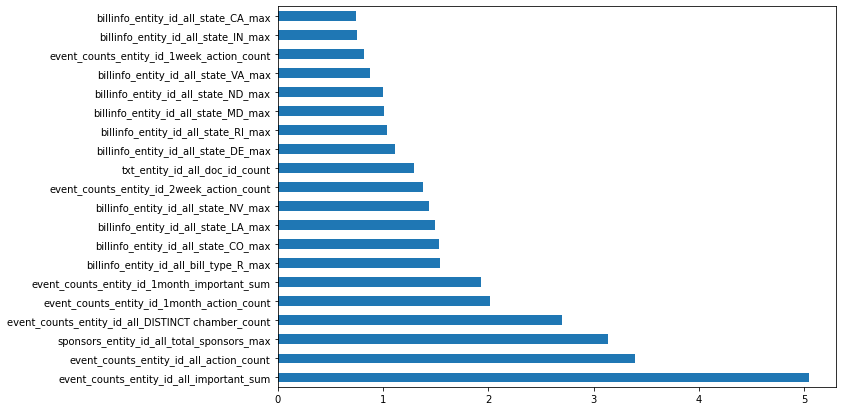

In [136]:
msk = feat_coeff > 0 
fig, ax = plt.subplots(figsize=(10, 7))
feat_coeff[msk][:20].plot(kind='barh', ax=ax)

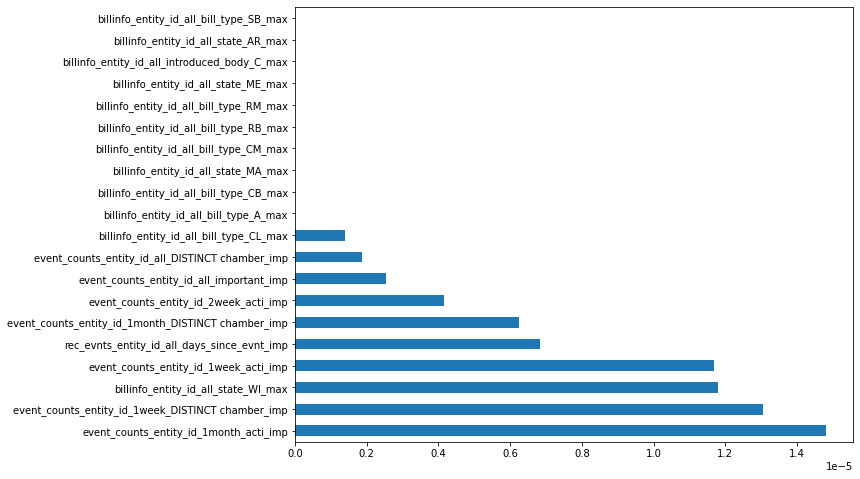

In [53]:
fig, ax = plt.subplots(figsize=(10, 8))
# feat_coeff[~msk & feat_coeff>0][-20:].plot(kind='barh', ax=ax)
feat_coeff[-20:].plot(kind='barh', ax=ax)

In [97]:
q = """
    select * from test_results.predictions where model_id={model_id}
""".format(model_id=model_ids[0])

predictions = pd.read_sql(q, db_conn)

In [98]:
predictions.head()

,model_id,entity_id,as_of_date,score,label_value,rank_abs_no_ties,rank_abs_with_ties,rank_pct_no_ties,rank_pct_with_ties,matrix_uuid,test_label_timespan
0,7095,217960,2012-07-01,0.44064,0,13768,13768,0.76754,0.76754,37454418cbb077415703d117fce09614,365 days
1,7095,217960,2012-07-08,0.39276,0,16074,16074,0.72860,0.72860,37454418cbb077415703d117fce09614,365 days
2,7095,217960,2012-07-15,0.32633,0,19860,19860,0.66467,0.66467,37454418cbb077415703d117fce09614,365 days
3,7095,217960,2012-07-22,0.29555,0,22059,22058,0.62754,0.62754,37454418cbb077415703d117fce09614,365 days
4,7095,217960,2012-07-29,0.29350,0,22208,22208,0.62502,0.62502,37454418cbb077415703d117fce09614,365 days


In [113]:
msk = (predictions['score'] > 0.8) & (predictions['score'] < 0.9)
predictions[msk]['label_value'].sum()/predictions[msk].shape[0]

0.7495934959349594

In [168]:
passage_prog_in_score_buckets = pd.DataFrame()
for i in np.arange(0.9, 0, -0.1):
    d = dict()
    d['score_threshold'] = round(i, 2)
#     d['upper_lim'] = i
    msk = (predictions['score'] >= i) 
#     & (predictions['score'] < i)
    d['num_records'] = predictions[msk].shape[0]
    d['passage_prob'] = predictions[msk]['label_value'].sum()/predictions[msk].shape[0]
    
    passage_prog_in_score_buckets = passage_prog_in_score_buckets.append(d, ignore_index=True)

In [169]:
passage_prog_in_score_buckets

,num_records,passage_prob,score_threshold
0,73.0,0.726027,0.9
1,1919.0,0.748828,0.8
2,5313.0,0.724261,0.7
3,8240.0,0.690534,0.6
4,11622.0,0.663999,0.5
5,15740.0,0.626175,0.4
6,21723.0,0.572757,0.3
7,31088.0,0.497394,0.2
8,44073.0,0.406689,0.1


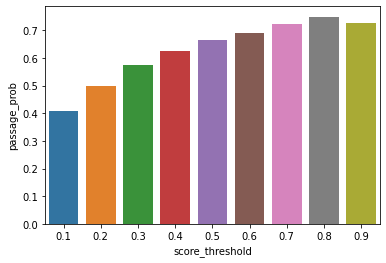

In [170]:
sns.barplot(data=passage_prog_in_score_buckets, x='score_threshold', y='passage_prob')